In [13]:
import os 
import numpy as np
import local_utils
import hausdorff_from_dir 
from pathlib import Path

In [14]:
datadir = Path('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/heterog_1000/MC_expt_2020-02-01-18-15/export_1000')
aemdir = datadir.joinpath('aem_data_1000')

In [15]:
data = (local_utils.load_obj(aemdir,'aem_data_it491'))[0]

In [16]:
data.shape

(5625,)

In [17]:
#Waveform 

#Get LM and HM from simpegskytem
import simpegskytem
from simpegskytem import Utils

simpegskytem_path = Path(simpegskytem.__file__).parent.parent.parent
print('simpegskytem path:\t',simpegskytem_path)

unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(simpegskytem_path.joinpath('aem-waveform/waveform_hm_312.txt'))
waveform_lm_312 = np.loadtxt(simpegskytem_path.joinpath('aem-waveform/waveform_lm_312.txt'))
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(simpegskytem_path.joinpath('aem-waveform/time_gates'))
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312


GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

ModuleNotFoundError: No module named 'simpegEM1D'

In [18]:
include_soundings = np.load(aemdir.joinpath('x_AEMgreaterThan1000.npy'))

In [10]:
mask = np.asarray([True if v in include_soundings else False for v in np.arange(125)])

In [44]:
DATA_culled = DATA[:,mask]

In [48]:
n_sounding = 125
DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')
DATA = DATA[:,mask]
DATA_output = DATA.flatten(order='F')

DATA_HM = -DATA[:times_hm_312.size,:]
DATA_LM = -DATA[times_hm_312.size:,:]


In [100]:
DATA.shape

(45, 80)

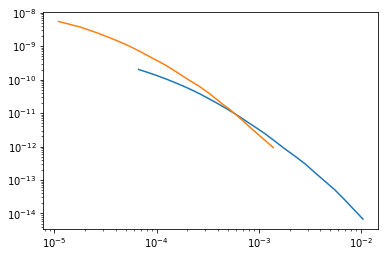

In [47]:
import matplotlib.pyplot as plt
plt.loglog(times_hm_312,DATA_HM[:,0])
plt.loglog(times_lm_312,DATA_LM[:,0])

In [101]:
AEM_mat = {}
for f in aemdir.iterdir():
    if not f.name.startswith('aem_data'):
        continue
    start = f.name.find('it') + 2
    end = f.name.find('.pkl')
    it = int(f.name[start:end])

    aem_data = local_utils.load_obj(aemdir,f.name[:-4])

    DATA_output = np.zeros((4,3600),dtype=float)
    for i_data,data in enumerate(aem_data):
        DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')
        DATA = DATA[:,mask]
        DATA_output[i_data,:] = DATA.flatten(order='F')
    AEM_mat['AEM_mat{}'.format(it)] = DATA_output


In [102]:
from scipy.io import savemat
savemat(aemdir.parent.joinpath('AEM_mat.mat'),AEM_mat)

In [21]:
varlist = local_utils.load_obj(aemdir.parent,'varlist_final_1000')
# savemat(aemdir.parent.joinpath('varlist_final.mat'),varlist)

In [72]:
len(aem_data)

4

### Re-create CF_mat

In [44]:
from simulationFFT import *

def create_CF_mat(varlist,it):
    nlay,nrow,ncol = (26, 20, 100)
    dx,dy,dz = (30,30,3)
    Lx,Ly,Lz = (dx*ncol,dy*nrow,dz*nlay)

    CF_glob = varlist['CF_glob'][it]
    CF_var = varlist['CF_var'][it]
    corr_len = varlist['corr_len'][it]
    corr_len_yx = varlist['corr_len_yx'][it]
    corr_len_zx = varlist['corr_len_zx'][it]
    vario_type = varlist['vario_type'][it]
    lcol = int(corr_len/dx)
    llay = int(corr_len*corr_len_zx/dz)
    lrow = int(corr_len*corr_len_yx/dy)
    seed = varlist['seed'][it]
    por_mean = varlist['por_mean'][it]
    por_var  = varlist['por_var'][it]
    inputs = [CF_glob,CF_var,corr_len,corr_len_yx,corr_len_zx,vario_type,seed,por_mean,por_var]
    cf_mat = simulFFT(nrow,nlay, ncol,
                     CF_glob,
                     CF_var,
                     vario_type,
                     lrow , llay, lcol,seed=seed)
    return cf_mat,inputs


CF_mat = {}
CF_array=  np.zeros((len(varlist['CF_glob']),26, 20, 100))
inputs = []
for it in range(len(varlist['CF_glob'])):
    if it%100==0:
        print('it = {}'.format(it))
    CF_mat['CF{}'.format(it)],temp = create_CF_mat(varlist,it)
    CF_array[it] = CF_mat['CF{}'.format(it)]
    inputs.append(temp)
inputs = np.asarray(inputs)

it = 0
it = 100
it = 200
it = 300
it = 400
it = 500
it = 600
it = 700
it = 800
it = 900


In [46]:
CF_array2 = CF_array[:500]

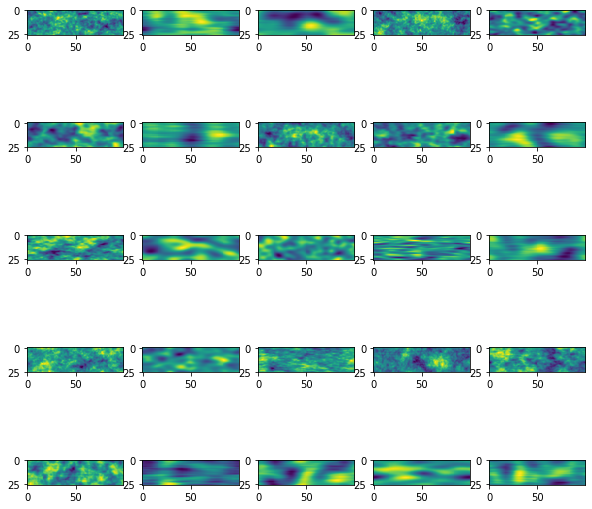

In [59]:
# np.unique(CF_array2,axis=0).shape
import matplotlib.pyplot as plt
f,axs= plt.subplots(5,5,figsize=(10,10))
it=0
for i in range(0,500,20):
    plt.sca(axs.flatten()[it])
    plt.imshow(CF_array2[i,:,10,:])
    plt.gca().set_aspect(1)
    it+=1


In [41]:
from scipy.io import savemat
savemat(aemdir.parent.joinpath('CF_mat2.mat'),CF_mat,do_compression=True)

In [96]:
for it in ucn_dict.keys():
    CF_glob = varlist['CF_glob'][it]
    CF_var = varlist['CF_var'][it]
    seed = varlist['seed'][it]
    corr_len = varlist['corr_len'][it]
    corr_len_yx = varlist['corr_len_yx'][it]
    corr_len_zx = varlist['corr_len_zx'][it]
    vario_type = varlist['vario_type'][it]

    #Create Gaussian Simulation
    lcol = int(corr_len/delr)
    llay = int(corr_len*corr_len_zx/delv)
    lrow = int(corr_len*corr_len_yx/delc)
    CF_mat['CF{}'.format(it)] = simulationFFT.simulFFT(nrow,nlay, ncol,CF_glob,
                                        CF_var,vario_type, lrow ,
                                        llay, lcol,seed=seed)
if saveyn:
    if ftype=='mat':
        from scipy.io import savemat
        savemat(dirname.joinpath('CF_mat.mat'),CF_mat, do_compression=True)
        print('saved {}'.format(dirname.joinpath('CF_mat.mat')))

Signature:
local_utils.create_CF_from_dir(
    ['dirname', 'ucn_dict=None', 'modsize=(26, 20, 100)', 'varlist=None', "ftype='mat'", 'saveyn=True'],
)
Docstring: <no docstring>
Source:   
def create_CF_from_dir(dirname,ucn_dict=None,
                   modsize = (26,20,100),
                   varlist=None,
                   ftype='mat',
                   saveyn=True):
    
    import simulationFFT

    nlay,nrow,ncol = modsize
    delv,delc,delr = (3,30,30)


    if varlist is None:
        varlist = load_obj(dirname,'varlist_final')
    if ucn_dict is None:
        try:
            ucn_dict = load_obj(dirname,'ucn_dict')
        except:
            ucn_dict = create_ucn_from_dir(dirname,totims = (1,180,360), saveyn=False)

    CF_mat = {}
    for it in ucn_dict.keys():
        CF_glob = varlist['CF_glob'][it]
        CF_var = varlist['CF_var'][it]
        seed = varlist['seed'][it]
        corr_len = varlist['corr_len'][it]
        corr_len_yx = varlist['corr_len_yx'][it]
        co

In [114]:
import pandas as pd
import seaborn as sns

varnames = ('AEM','conc')
section_names = ('0_500','501_1000')
AEM_unconf = pd.read_csv(datadir.joinpath('matrixDGSA_AEM_0_500.csv'))



In [74]:
AEM_unconf.rename(columns={'Unnamed: 0':'var'},inplace=True)
AEM_unconf.set_index('var',inplace=True)

In [109]:
msk = (AEM_unconf.max(axis=0) > .27)
AEM_plot = AEM_unconf.loc[msk,msk]

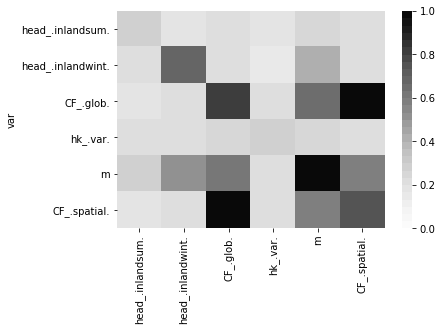

In [127]:
# cmap = sns.cubehelix_palette(8, start=.5, rot=-.75,reverse=True,as_cmap=True)
cmap = sns.color_palette("Greys",n_colors=30)
# cmap = sns.color_palette("cubehelix", 30)
sb.heatmap(AEM_plot,vmin=0,vmax=1,cmap=cmap)

TypeError: unhashable type: '_ColorPalette'

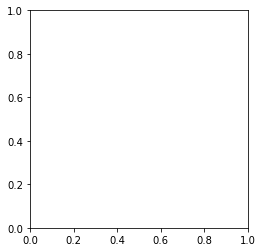

In [77]:
plt.imshow(AEM_unconf,vmin=0,vmax=1,cmap=cmap)


[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]